In [41]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
import os
import tensorflow as tf
import keras
from keras import layers
import cv2
from sklearn.model_selection import train_test_split
from keras.callbacks import TensorBoard
import tqdm

In [42]:
# hyper-parameters
ROOT_FOLDER = "../.."
DATA_FOLDER = os.path.join(ROOT_FOLDER, "data")
TRAIN_FOLDER = os.path.join(DATA_FOLDER, "train_set")
TEST_FOLDER = os.path.join(DATA_FOLDER, "test_set")
PROCESSED_DATA = os.path.join(ROOT_FOLDER, 'processed_data')
TEMPLATE_FOLDER = os.path.join(PROCESSED_DATA, 'templates')

In [43]:
def create_dataset(processed_data=True, train=True, anomaly=False):
    """
    gather all files from all folders in the train or test folder

    :type: str representing which files we want
    :return: list containing
    """

    # define whether to use train or test set
    if train:
        data_set = 'train_set'
    else:
        data_set = 'test_set'

    # define whether to use processed or original data
    if processed_data:
        data_folder = PROCESSED_DATA
        templates = [1,2,3,4,5,6]
    else:
        data_folder = DATA_FOLDER
        template_folder = os.path.join(DATA_FOLDER, data_set)
        templates = os.listdir(template_folder)

    # choose anomalous dice if set as parameter
    if anomaly:
        templates = ["ano"]

    # initialize return types
    data = []
    label = []

    for template in templates:
        # get the folder name, all filenames inside it, and make a list of all the image files inside
        train_folder = os.path.join(data_folder, data_set)
        folder = os.path.join(train_folder, str(template))
        filenames = os.listdir(folder)
        files = [file for file in filenames if ".png" in file]

        for file in files:
            img = Image.open(os.path.join(folder,file))
            data.append(np.array(img))
            label.append(template)
            # if len(data)%100==0:
            #   break
            
    label= np.array(label).reshape(-1,1)

    return data, label


In [44]:
def SSIMLoss(y_true, y_pred):
    y_true = tf.cast(y_true,tf.float32)
    y_pred = tf.cast(y_pred,tf.float32)
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred,1.0))

In [45]:
def split_and_preprocess_dataset(data, split = True):
    data = np.array(data)
    preprocessed_data = data/255
    preprocessed_data = np.expand_dims(preprocessed_data, axis=3)

    if not split:
        return preprocessed_data, _, _, _, _, _, _, _

    # split data in train/val/test set
    train_val_data, test_data, train_val_labels, test_labels = train_test_split(
        preprocessed_data, 
        labels,
        test_size=0.2, 
        random_state=42, 
        shuffle=True
    )

    train_data, val_data, train_labels, val_labels = train_test_split(
        train_val_data, 
        train_val_labels,
        test_size=0.3, 
        random_state=42, 
        shuffle=True
    )

    return train_val_data, test_data, train_val_labels, test_labels, train_data, val_data, train_labels, val_labels

In [46]:
# gather, process and preprocess all training data.

data, labels = create_dataset(processed_data=True, train=True)
train_val_data, test_data, train_val_labels, test_labels, train_data, val_data, train_labels, val_labels = split_and_preprocess_dataset(data)

In [ ]:
# gather, process and preprocess all training data.

anomalies, _ = create_dataset(processed_data=True, train=True, anomaly=True)
anomalies, _, _, _, _, _, _, _ = split_and_preprocess_dataset(anomalies, split = False)
#anomalies = [x.reshape(128, 128, 1) for x in anomalies]

In [ ]:
inputs = tf.keras.Input(shape=(128, 128, 1), name='input_layer')


In [ ]:
# Conv Block 1 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_1')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_1')(encoded)
# Conv Block 2 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_2')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_2')(encoded)
# Conv Block 3 -> BatchNorm->leaky Relu
encoded = tf.keras.layers.Conv2D(64, kernel_size=3, strides=2, padding='same', name='conv_3')(encoded)
encoded = tf.keras.layers.BatchNormalization(name='batchnorm_3')(encoded)
encoded = tf.keras.layers.LeakyReLU(name='leaky_relu_3')(encoded)

2022-02-09 10:56:57.390309: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/admin1/anaconda3/envs/pytorch/lib/python3.9/site-packages/cv2/../../lib64:
2022-02-09 10:56:57.390368: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-02-09 10:56:57.390425: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (venkys-pc): /proc/driver/nvidia/version does not exist
2022-02-09 10:56:57.391029: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# DeConv Block 1-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(encoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_4')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_4')(decoded)
# DeConv Block 2-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_5')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_5')(decoded)
# DeConv Block 3-> BatchNorm->leaky Relu
decoded = tf.keras.layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(decoded)
decoded = tf.keras.layers.BatchNormalization(name='batchnorm_6')(decoded)
decoded = tf.keras.layers.LeakyReLU(name='leaky_relu_6')(decoded)

In [ ]:
outputs = tf.keras.layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(decoded)


In [ ]:
autoencoder = tf.keras.Model(inputs, outputs)
optimizer = tf.keras.optimizers.Adam(lr = 0.0005)
autoencoder.compile(optimizer=optimizer, loss=SSIMLoss)

/home/admin1/anaconda3/envs/pytorch/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
autoencoder.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 128, 128, 1)]     0         
                                                                 
 conv_1 (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 128, 128, 32)     128       
 tion)                                                           
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 128, 128, 32)      0         
                                                                 
 conv_2 (Conv2D)             (None, 64, 64, 64)        18496     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 64, 64, 64)       256       
 tion)                                                       

In [ ]:
# dot_img_file = '../assets/autoencoder.png'
# tf.keras.utils.plot_model(autoencoder, to_file=dot_img_file, show_shapes=True)

In [ ]:
!rm -rf ./logs/


In [ ]:
from keras.callbacks import TensorBoard


In [ ]:
hist=autoencoder.fit(train_val_data, train_val_data,
                epochs=4,
                batch_size=128,
                shuffle=True,
                validation_data=(test_data, test_data), callbacks=[TensorBoard(log_dir='logs/')])

Epoch 1/10


2022-02-09 10:57:07.306854: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 268435456 exceeds 10% of free system memory.
2022-02-09 10:57:08.001391: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 268435456 exceeds 10% of free system memory.
2022-02-09 10:57:08.398841: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 268435456 exceeds 10% of free system memory.
2022-02-09 10:57:11.002282: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 268435456 exceeds 10% of free system memory.
2022-02-09 10:57:11.930546: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 268435456 exceeds 10% of free system memory.


4/4 [==============================] - 100s 23s/step - loss: 0.8921 - val_loss: 0.4325
Epoch 2/10
4/4 [==============================] - 95s 24s/step - loss: 0.6824 - val_loss: 0.4307
Epoch 3/10
4/4 [==============================] - 102s 26s/step - loss: 0.5204 - val_loss: 0.4288
Epoch 4/10
4/4 [==============================] - 85s 22s/step - loss: 0.4215 - val_loss: 0.4265
Epoch 5/10
4/4 [==============================] - 97s 26s/step - loss: 0.3572 - val_loss: 0.4240
Epoch 6/10
4/4 [==============================] - 110s 30s/step - loss: 0.2973 - val_loss: 0.4214
Epoch 7/10
4/4 [==============================] - 104s 26s/step - loss: 0.2505 - val_loss: 0.4186
Epoch 8/10
4/4 [==============================] - 87s 23s/step - loss: 0.2178 - val_loss: 0.4155
Epoch 9/10
4/4 [==============================] - 80s 20s/step - loss: 0.1945 - val_loss: 0.4119
Epoch 10/10
4/4 [==============================] - 91s 23s/step - loss: 0.1754 - val_loss: 0.4082


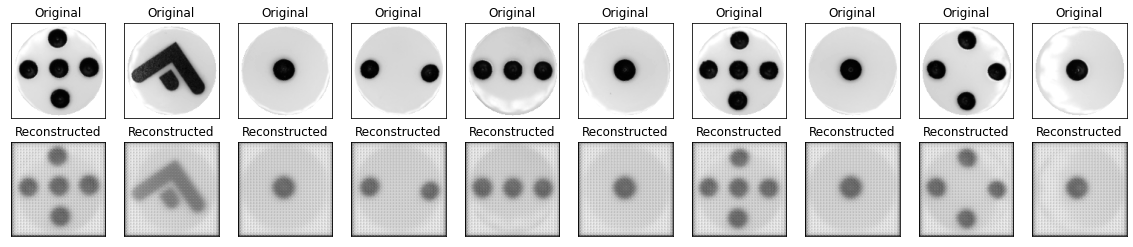

In [ ]:
decoded_imgs = autoencoder.predict(test_data)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_data[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

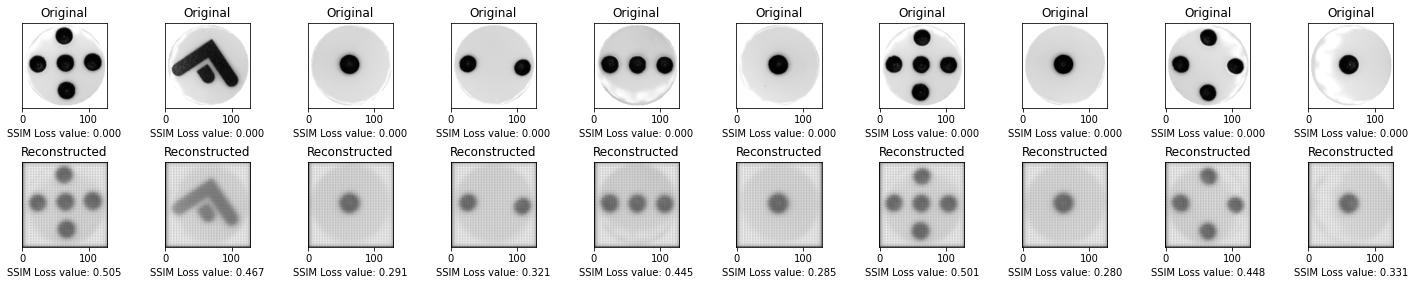

In [ ]:
decoded_imgs = autoencoder.predict(test_data)
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # Display original
    ax = plt.subplot(2, n, i)
    plt.imshow(test_data[i].reshape(128, 128))
    plt.gray()
    plt.title("Original")
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(test_data[i], test_data[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )

    # Display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.title("Reconstructed")
    plt.imshow(decoded_imgs[i].reshape(128, 128))
    plt.gray()
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(decoded_imgs[i], test_data[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a))
plt.tight_layout()
plt.show()

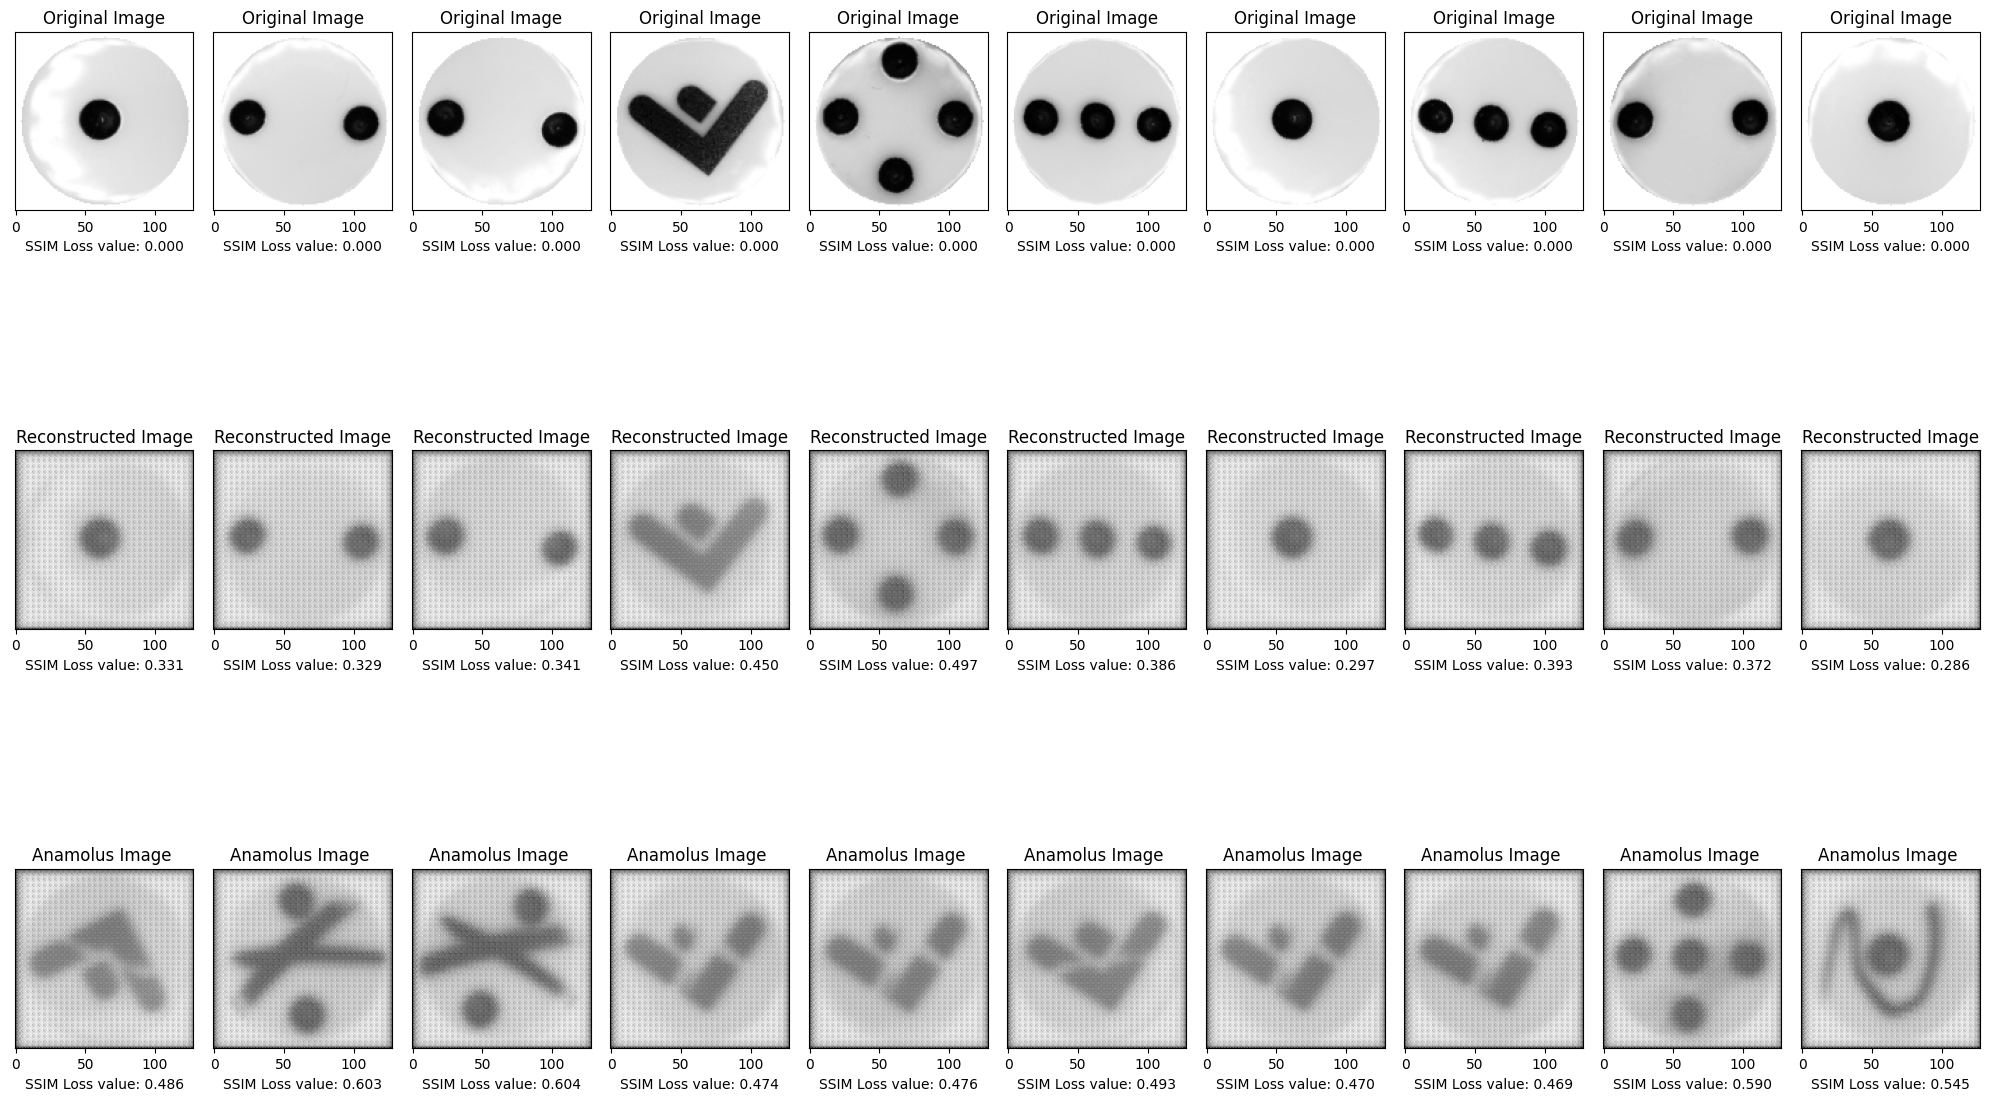

In [ ]:
%matplotlib inline
n = 10 # how many encoded and decoded images we will display
decoded_imgs= autoencoder.predict(test_data)

decoded_mnistimgs= autoencoder.predict(anomalies)
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(n, n+10):
    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(test_data[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(test_data[i], test_data[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed good data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n )
    plt.imshow(decoded_imgs[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(decoded_imgs[i], test_data[i])
    ax.set_title("Reconstructed Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + 2*n)
    plt.imshow(decoded_mnistimgs[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(anomalies[i], decoded_mnistimgs[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
plt.tight_layout()
plt.show()

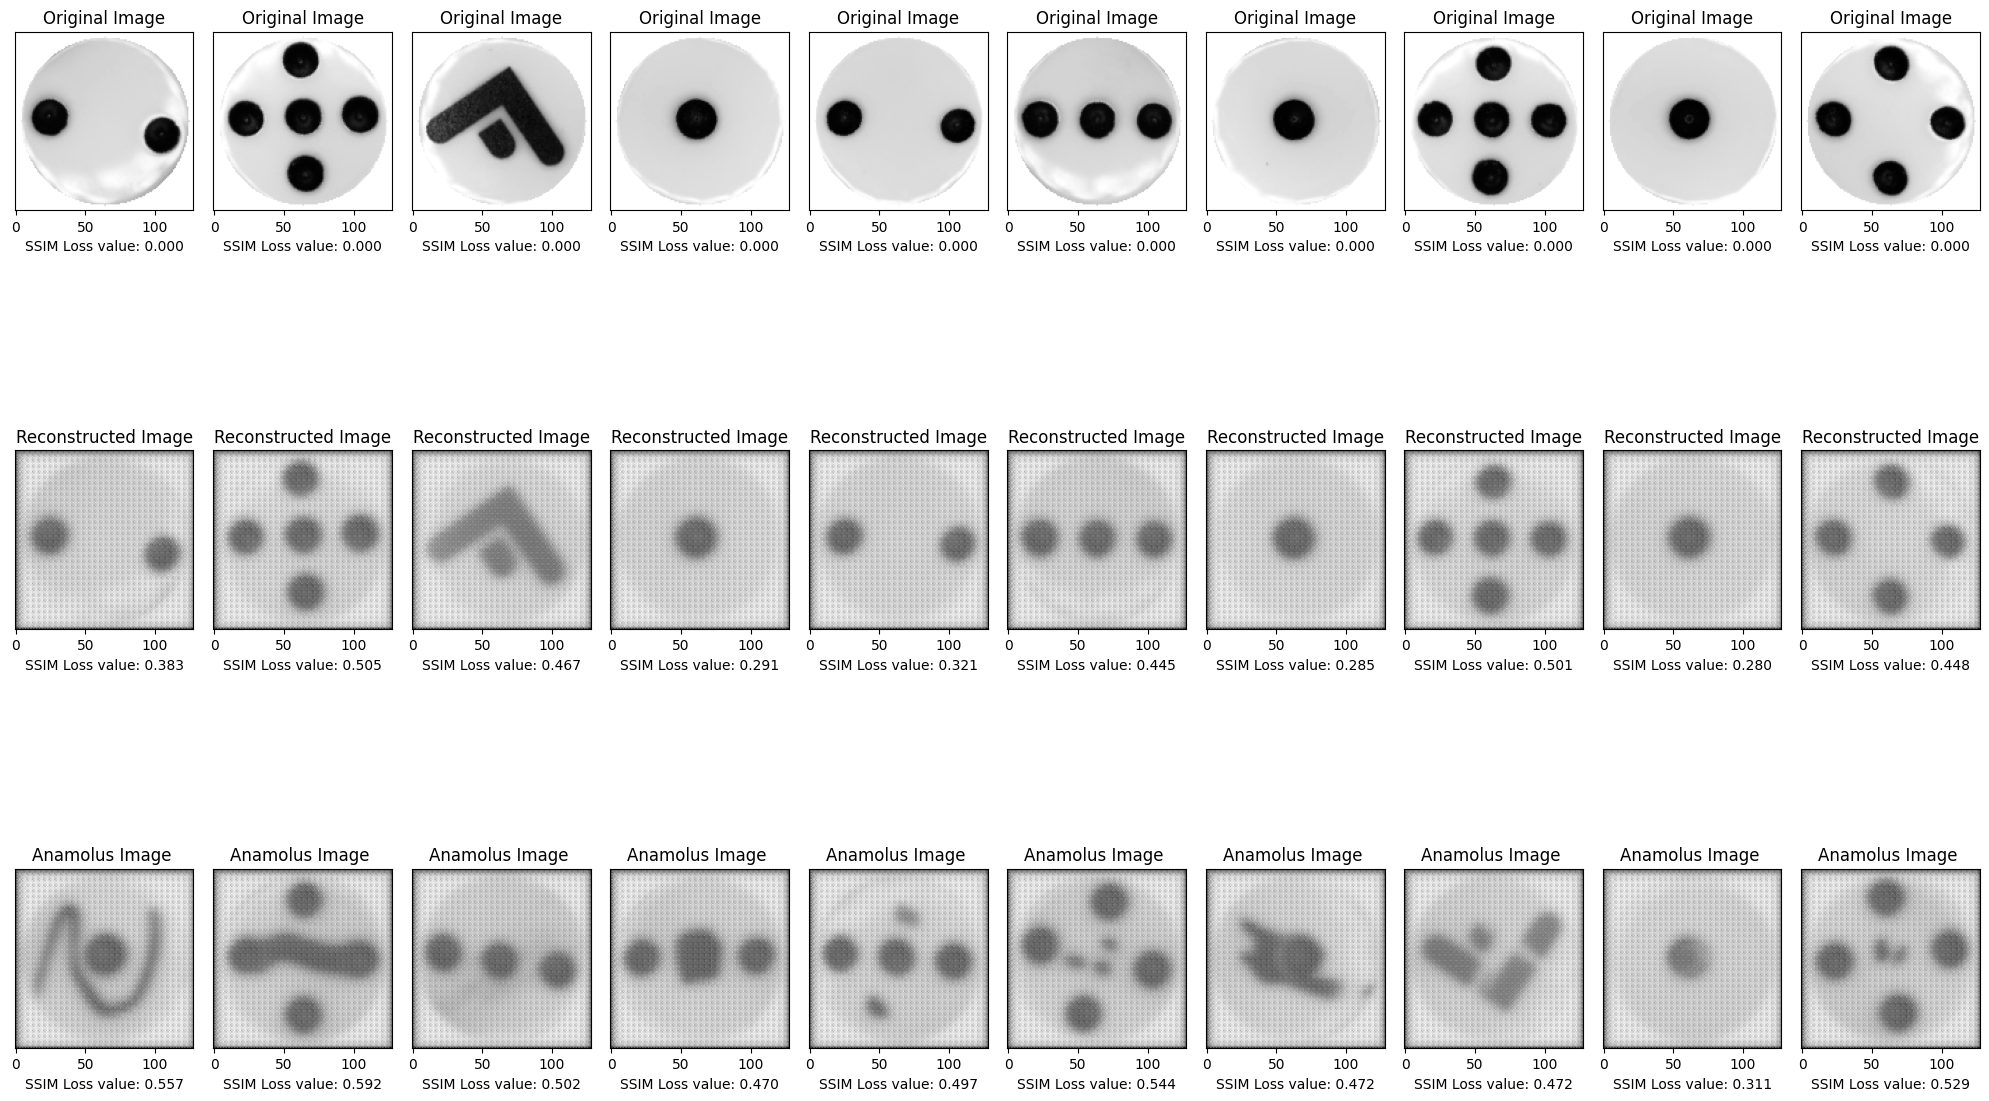

In [ ]:
plt.figure(figsize=(20, 14), dpi=100)
plt.subplots_adjust( wspace=0.1, hspace=0.07)
plt_a=1
for i in range(n):
    # Original training dataset vs Original training
    ax = plt.subplot(3, n, plt_a   )
    plt.imshow(test_data[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value_a = SSIMLoss(test_data[i], test_data[i])
    ax.set_title("Original Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed good data  vs Original training data
    ax = plt.subplot(3, n, plt_a + n )
    plt.imshow(decoded_imgs[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)    
    value_a = SSIMLoss(decoded_imgs[i], test_data[i])
    ax.set_title("Reconstructed Image")
    label = 'SSIM Loss value: {:.3f}'
    ax.set_xlabel(label.format(value_a) )
    
    # Reconstructed anomalous data  vs Original training data
    ax = plt.subplot(3, n, plt_a + 2*n)
    plt.imshow(decoded_mnistimgs[i].reshape(128,128))
    ax.get_xaxis().set_visible(True)
    ax.get_yaxis().set_visible(False)
    value = SSIMLoss(anomalies[i], decoded_mnistimgs[i])
    label = 'SSIM Loss value: {:.3f}'
    ax.set_title("Anamolus Image " )
    ax.set_xlabel(label.format(value) )
    plt_a+=1
plt.tight_layout()
plt.show()

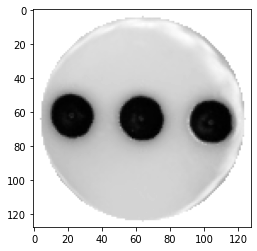

In [ ]:
img = Image.open("../../processed_data/train_set/3/16_09_21_03_000.png")
plt.imshow(img, cmap="gray")
img = np.array(img)/255
decoded_imgs= autoencoder.predict(img.reshape(1,128, 128, 1))

(1, 128, 128, 1)


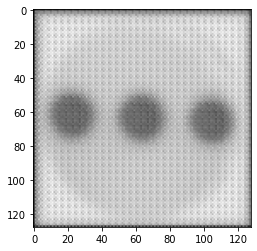

In [ ]:
print(decoded_imgs.shape)
plt.imshow(decoded_imgs[0])

In [ ]:
np.array([np.array(img).reshape(128, 128, 1)]).shape

(1, 128, 128, 1)

In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def print_stats(predictions, labels):
    """
    Coth prints the stats of the prediction, and returns them as an array

    :predictions: list containing predictions
    :labels: list containing labels
    :return: list containing floats f1, accuracy, precision, recall
    """
    f1 = f1_score(labels, predictions)
    acc = accuracy_score(labels, predictions)
    prec = precision_score(labels, predictions)
    rec = recall_score(labels, predictions)

    print("f1 = {}".format(f1_score(labels, predictions)))
    print("Accuracy = {}".format(accuracy_score(labels, predictions)))
    print("Precision = {}".format(precision_score(labels, predictions)))
    print("Recall = {}".format(recall_score(labels, predictions)))

    return [f1, acc, prec, rec]


def SSIMLoss(y_true, y_pred):
    """
    numpy version of the SSIM loss function

    :y_true: the original image before being processed
    :y_pred: the same image after being processed by the autoencoder moder
    :return: float between 0 and 1 giving a measure of distance between the 2 parameters
    """
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))


def predictor(ano_pred, norm_pred, threshold):
    """
    predictor classifies prediction by comparing with a threshold

    :ano_pred: a list containing the predictions for anomalies between 0 and 1
    :norm_pred: a list containing the predictions for the normal samples between 0 and 1
    :return; 2 lists, 1 containing prediction and the other containing the labels.
    """
    threshold = np.float32(threshold)
    predictions = []
    labels = []

    for pred in ano_pred:
        labels.append(1)
        if pred > threshold:
            predictions.append(1)
        else:
            predictions.append(0)

    for pred in norm_pred:
        labels.append(0)
        if pred > threshold:
            predictions.append(1)

        else:
            predictions.append(0)

    return predictions, labels


def make_predictions(model, anomalies, normals):
    """
    Function implementing SSIMloss on the both anomalies and normal samples

    :model: autoencoder or any other model taking in 128x128 images
    :anomalies: list of np arrays of 128 x 128
    :normals: list of np arrays of 128 x 128
    :return: a list containing 4 metrics, f1, accuracy, precision, recall
    """
    ano_predictions = []
    norm_predictions = []
    for ano in anomalies:
#         print(ano.shape)
        result = model.predict(ano.reshape(1,128, 128, 1))#.reshape(128, 128, 1)
#         print(result.shape)
        ano_predictions.append(SSIMLoss(ano, result).numpy())

    for sample in tqdm.tqdm(normals):
#         print(sample.shape)
        result = model.predict(sample.reshape(1,128, 128, 1))#.reshape(128, 128, 1)
        norm_predictions.append(SSIMLoss(sample, result).numpy())

    threshold = (
        np.mean(norm_predictions)
        + (np.mean(norm_predictions) + np.mean(ano_predictions)) / 12
    )

    predictions, labels = predictor(ano_predictions, norm_predictions, threshold)

    return print_stats(predictions, labels)


In [ ]:
f1, acc, prec, rec= make_predictions(autoencoder, anomalies, test_data)

100%|██████████| 120/120 [00:34<00:00,  3.48it/s]

f1 = 0.6722689075630252
Accuracy = 0.7784090909090909
Precision = 0.6349206349206349
Recall = 0.7142857142857143
